<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/ml/torch/mnist_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST で拡散モデル

[ここ](https://github.com/TeaPearce/Conditional_Diffusion_MNIST)を参考にMNISTで拡散モデルを作成

## モデル定義

### 層の定義

ResConvNet = 畳み込みによるResNet(残差ネット)。

ただし活性化層は$GRLU(x)≡x\cdot N(x;0,I)$。

In [2]:
import torch
import torch.nn as nn

class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)

            # this adds on correct residual in case channels have increased
            if self.same_channels:
                # 2層の畳み込みを用いた ResNet
                out = x + x2
            else:
                # 1層の畳み込みをした上で
                # 1層の畳み込みを用いた ResNet
                out = x1 + x2
            return out / 1.414
        else:
            # ResNet ではなく通常の2層の畳み込み
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

UNet のダウンサンプリング = ResConvNet + Max Pooling

In [3]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

UNet のアップサンプリング = 転置畳み込み + ResConvNet

skip connection 付き。

In [4]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

timestamp embedding と context embedding に使用する EmbedFC 層

In [5]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

timestamp と context を embedding する Unet。

以下の順で処理:
1. UnetDown でダウンスケール
2. timestamp と context (one-hot encoded) を embedding
3. UnetUp でアップスケール
  - UnetDown の結果と skip connection
  - embedding した timestamp $t_e$ と context $c_e$ で activation
  - activation は $a_{L+1}=c_e a_L + t_e$ で実施

In [6]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep,
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask

        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # embedding activation (1st arg) & skip connection (2nd arg)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

### 拡散モデルの定義

Encoding (diffusion process) のパラメータを定義
- $\beta_t$: 下限$\beta_1$, 上限$\beta_2$ の等差数列. 数列の数は $T$.
- $\alpha_t$: $1-\beta_t$ あるいは encoder transition の係数
- $\bar{\alpha}_t$: $\alpha_t$ の累積積

In [7]:
def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)

    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # α_t
        "oneover_sqrta": oneover_sqrta,  # 1/√(α_t)
        "sqrt_beta_t": sqrt_beta_t,  # √(β_t)
        "alphabar_t": alphabar_t,  # \bar{α_t}
        "sqrtab": sqrtab,  # √(\bar{α_t})
        "sqrtmab": sqrtmab,  # √(1-\bar{α_t})
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-α_t)/√(1-\bar{α_t})
    }

ノイズを最適化する手法を採用。

In [8]:
import numpy as np

class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """
        # t ~ Uniform(0, n_T)
        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)
        # eps ~ N(0, 1)
        noise = torch.randn_like(x)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )
        # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)

        # return MSE between added noise, and our predicted noise
        return self.loss_mse(
            noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        # x_T ~ N(0, 1), sample initial noise
        x_i = torch.randn(n_sample, *size).to(device)
        # context for us just cycles throught the mnist labels
        c_i = torch.arange(0,10).to(device)
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        # makes second half of batch context free
        context_mask[n_sample:] = 1.

        # keep track of generated steps in case want to plot something
        x_i_store = []
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]

            # Classifier-Free Guidance
            eps = (1 + guide_w) * eps1 - guide_w * eps2
            x_i = x_i[:n_sample]

            # denoising
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )

            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

モデルのインスタンス生成

In [9]:
# 128 ok, 256 better (but slower)
n_feat = 128
n_classes = 10
n_T = 400 # 500
device = "cuda:0"

ddpm = DDPM(
    nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes),
    betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1).to(device)
# optionally load a model
# ddpm.load_state_dict(torch.load("./data/diffusion_outputs/ddpm_unet01_mnist_9.pth"))

## 学習設定

データセットの用意

In [10]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

batch_size = 256

# mnist is already normalised 0 to 1
tf = transforms.Compose([transforms.ToTensor()])

dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 158217307.69it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 98886280.67it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43812226.54it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5073376.50it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



学習方法を定義

In [11]:
from tqdm import tqdm

n_epoch = 20

def train(ddpm, device, dataloader, optim, epoch):
    global n_epoch
    ddpm.train()

    # linear lrate decay
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    pbar = tqdm(dataloader)
    loss_ema = None
    for x, c in pbar:
        optim.zero_grad()
        x = x.to(device)
        c = c.to(device)
        loss = ddpm(x, c)
        loss.backward()

        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()

        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()
    return x, c

## 可視化関数の定義

生成画像をグリッドに並べて1枚の画像にする関数

In [12]:
import os
from torchvision.utils import save_image, make_grid

def create_image(x_gen, x, classes, w, epoch, n_sample, save_dir):
    # append some real images at bottom, order by class also
    x_real = torch.Tensor(x_gen.shape).to(device)
    for class_idx in range(n_classes):
        for sample_idx in range(int(n_sample/n_classes)):
            try:
                idx = torch.squeeze((classes == class_idx).nonzero())[sample_idx]
            except:
                idx = 0
            x_real[class_idx + (sample_idx * n_classes)] = x[idx]

    x_all = torch.cat([x_gen, x_real])

    # make a united image by grid
    grid = make_grid(x_all*-1 + 1, nrow=10)
    save_path = os.path.join(save_dir, f"image_ep{epoch}_w{w}.png")
    save_image(grid, save_path)
    print(f"saved image at {save_path}")

生成過程のアニメーションを作るために複数のプロットを作成する関数を定義

In [13]:
def animate_diff(axs, n_sample, i, x_gen_store):
    print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
    plots = []
    for row in range(int(n_sample/n_classes)):
        for col in range(n_classes):
            axs[row, col].clear()
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])

            #plots.append(
            #    axs[row, col].imshow(
            #        x_gen_store[i,(row*n_classes)+col,0],
            #        cmap='gray'))
            plots.append(
                axs[row, col].imshow(
                    -x_gen_store[i,(row * n_classes) + col,0],
                    cmap='gray',
                    vmin=(-x_gen_store[i]).min(),
                    vmax=(-x_gen_store[i]).max()))
    return plots

生成過程のアニメーション GIF を作成する関数を定義

In [14]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def create_gif(x_gen_store, ep, w, n_sample, save_dir):
    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(
        nrows=int(n_sample/n_classes),
        ncols=n_classes,
        sharex=True,
        sharey=True,
        figsize=(8,3))

    ani = FuncAnimation(
        fig, lambda x, y: animate_diff(axs, n_sample, x, y),
        fargs=[x_gen_store],
        interval=200, blit=False, repeat=True,
        frames=x_gen_store.shape[0])

    ani_path = os.path.join(save_dir, f"gif_ep{ep}_w{w}.gif")
    ani.save(
        ani_path,
        dpi=100, writer=PillowWriter(fps=5))
    print(f"saved image at {ani_path}")

推論とその結果から生成画像と生成過程の動画を作成する関数を定義

In [15]:
def test(ddpm, device, x, c, ep, save_dir):
    # for eval, save an image of currently generated samples (top rows)
    # followed by real images (bottom rows)
    ddpm.eval()
    with torch.no_grad():
        n_sample = 4*n_classes

        ws_test = [0.0, 0.5, 2.0] # strength of generative guidance
        for w_i, w in enumerate(ws_test):

            x_gen, x_gen_store = ddpm.sample(
                n_sample, (1, 28, 28), device, guide_w=w)
            create_image(x_gen, x, c, w, ep, n_sample, save_dir)
            create_gif(x_gen_store, ep, w, n_sample, save_dir)

## 学習

epoch 0


loss: 0.0487: 100%|██████████| 235/235 [01:48<00:00,  2.16it/s]



saved image at ./data/diffusion_outputs10/image_ep0_w0.0.png
saved image at ./data/diffusion_outputs10/gif_ep0_w0.0.gif

saved image at ./data/diffusion_outputs10/image_ep0_w0.5.png
saved image at ./data/diffusion_outputs10/gif_ep0_w0.5.gif

saved image at ./data/diffusion_outputs10/image_ep0_w2.0.png
saved image at ./data/diffusion_outputs10/gif_ep0_w2.0.gif
epoch 1


loss: 0.0384: 100%|██████████| 235/235 [01:48<00:00,  2.17it/s]


epoch 2


loss: 0.0352: 100%|██████████| 235/235 [01:48<00:00,  2.17it/s]


epoch 3


loss: 0.0323: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 4


loss: 0.0317: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 5


loss: 0.0294: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 6


loss: 0.0297: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 7


loss: 0.0282: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 8


loss: 0.0281: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 9


loss: 0.0277: 100%|██████████| 235/235 [01:47<00:00,  2.19it/s]


epoch 10


loss: 0.0270: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 11


loss: 0.0264: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 12


loss: 0.0263: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 13


loss: 0.0254: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 14


loss: 0.0256: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 15


loss: 0.0253: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 16


loss: 0.0251: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 17


loss: 0.0252: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 18


loss: 0.0249: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s]


epoch 19


loss: 0.0245: 100%|██████████| 235/235 [01:47<00:00,  2.19it/s]



saved image at ./data/diffusion_outputs10/image_ep19_w0.0.png
saved image at ./data/diffusion_outputs10/gif_ep19_w0.0.gif

saved image at ./data/diffusion_outputs10/image_ep19_w0.5.png
saved image at ./data/diffusion_outputs10/gif_ep19_w0.5.gif

saved image at ./data/diffusion_outputs10/image_ep19_w2.0.png
saved image at ./data/diffusion_outputs10/gif_ep19_w2.0.gif


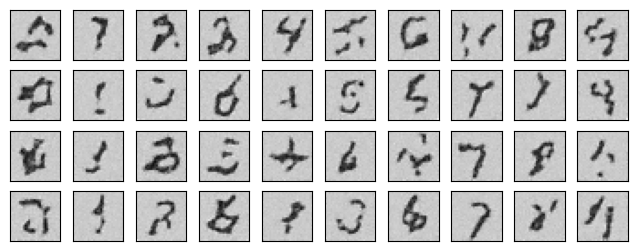

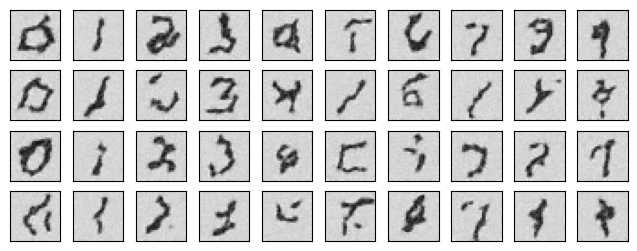

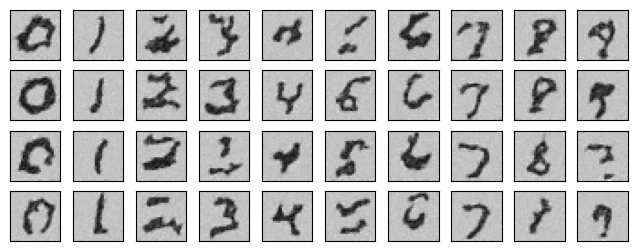

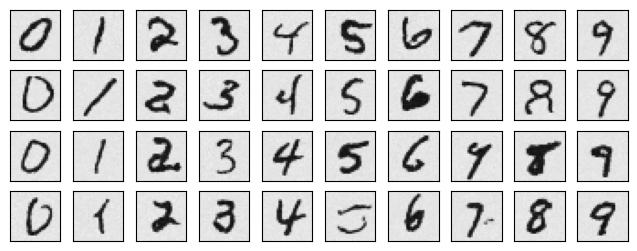

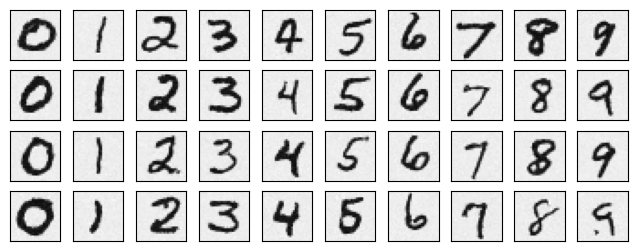

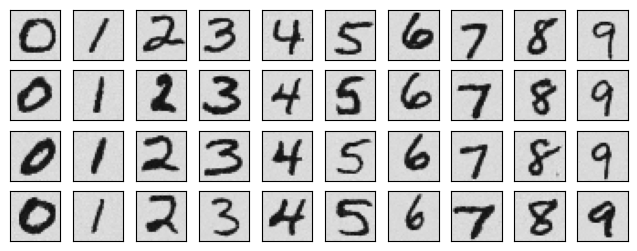

In [16]:
save_dir = './data/diffusion_outputs10/'
os.makedirs(save_dir, exist_ok=True)

lrate = 1e-4
optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

save_model = False
for ep in range(n_epoch):
    print(f'epoch {ep}')
    x, c = train(ddpm, device, dataloader, optim, ep)

    if ep == 0 or ep == int(n_epoch-1):
        test(ddpm, device, x, c, ep, save_dir)

    # optionally save model
    if save_model and ep == int(n_epoch-1):
        torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

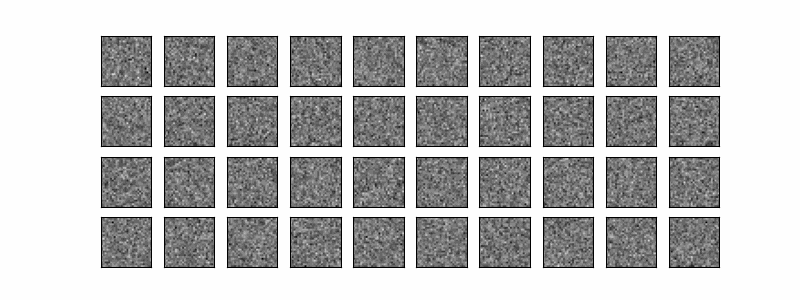

In [17]:
from IPython.display import Image

Image(os.path.join(save_dir, "gif_ep0_w2.0.gif"), format='png')

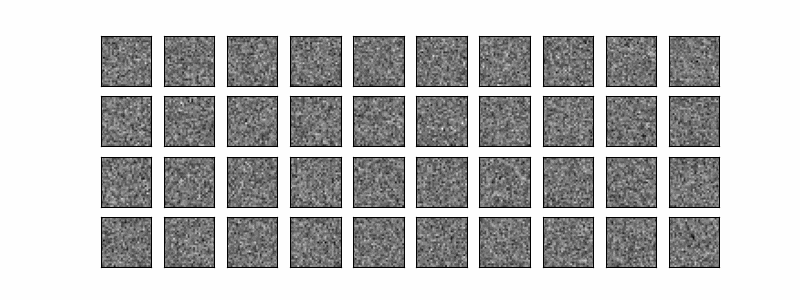

In [18]:
Image(os.path.join(save_dir, "gif_ep19_w2.0.gif"), format='png')